In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pickle
from quantiphy import Quantity as Q # pip3 install quantiphy
from scipy.signal import find_peaks
%matplotlib inline

from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Rectangle

def addsubfiglabels(axx,skip=0):
    try:
        len(axx)
    except TypeError:
        return
    ascii_letters = 'abcdefghijklmnopqrstuvwxyz'*(len(axx.ravel())//26+1)
    for letter,ax in zip(ascii_letters[skip:],axx.ravel()):
        at = AnchoredText(letter,frameon=True, loc='upper left')#prop=dict(size=15)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)

notes:

multimeter readings 

1.6 1.4 micro amp

voltage +2.448 -1.258

generator:

1.855vpp

300mv offset

In [2]:
# all data folders
all_folders = sorted([folder for folder in os.listdir() if folder.startswith("varyamp_")])
all_folders

['varyamp_1558', 'varyamp_1559', 'varyamp_1560']

In [3]:
all_folders = ['varyamp_1560','varyamp_1558']

In [4]:
%%time
datafolder = "varyamp_1560/"
raw_data=[]
for file in os.listdir(datafolder)[:10]:
    data = ""
    with open(f"{datafolder}{file}","r") as f:
        data = f.readlines()
    raw_data.append( [int(d.split(",")[0]) for d in data[25:]] )
raw_data = np.array(raw_data)

CPU times: user 57.5 ms, sys: 277 µs, total: 57.8 ms
Wall time: 57.5 ms


In [5]:
header = data[:25]
header

['Format,1.0B,\n',
 'Memory Length,10000,Memory Length,10000,\n',
 'IntpDistance,0,IntpDistance,0,\n',
 'Trigger Address,4999,Trigger Address,4999,\n',
 'Trigger Level,1.040E+00,Trigger Level,1.040E+00,\n',
 'Source,CH1,Source,CH2,\n',
 'Vertical Units,V,Vertical Units,V,\n',
 'Vertical Units Div,0,Vertical Units Div,0,\n',
 'Vertical Units Extend Div,16,Vertical Units Extend Div,16,\n',
 'Label,,Label,,\n',
 'Probe Type,0,Probe Type,0,\n',
 'Probe Ratio,1.000e+01,Probe Ratio,1.000e+00,\n',
 'Vertical Scale,5.000e-01,Vertical Scale,1.000e+00,\n',
 'Vertical Position,-1.820e+00,Vertical Position,0.000e+00,\n',
 'Horizontal Units,S,Horizontal Units,S,\n',
 'Horizontal Scale,2.000E-05,Horizontal Scale,2.000E-05,\n',
 'Horizontal Position,0.000E+00,Horizontal Position,0.000E+00,\n',
 'Horizontal Mode,Main,Horizontal Mode,Main,\n',
 'SincET Mode,Real Time,SincET Mode,Real Time,\n',
 'Sampling Period,2.000e-08,Sampling Period,2.000e-08,\n',
 'Horizontal Old Scale,2.000E-05,Horizontal Old Sca

In [6]:
scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
print(scope_settings)
trigger_level = float(data[4].split(",")[1])
vert_scale = float(data[12].split(",")[1])
vert_pos = float(data[13].split(",")[1])
vert_units = float(data[8].split(",")[1])
SamplingPeriod = float(data[19].split(",")[1])
trigger_level,vert_scale,vert_pos,np.max(raw_data),np.min(raw_data)

['Trigger Level,1.040E+00,Trigger Level,1.040E+00', 'Vertical Scale,5.000e-01,Vertical Scale,1.000e+00', 'Vertical Position,-1.820e+00,Vertical Position,0.000e+00', 'Horizontal Scale,2.000E-05,Horizontal Scale,2.000E-05', 'Sampling Period,2.000e-08,Sampling Period,2.000e-08']


(1.04, 0.5, -1.82, 100, -2)

In [7]:
vert_scaleLED = float(data[12].split(",")[3])
vert_posLED = float(data[13].split(",")[3])
vert_unitsLED = float(data[8].split(",")[3])
def get_ledvoltage(oscilloscope_led):
    return oscilloscope_led*vert_scaleLED/vert_unitsLED-vert_posLED
def get_apdvoltage(oscilloscope_apd):
    return oscilloscope_apd*vert_scale/vert_units-vert_pos

In [36]:
%%time
tempdatafile = "read03_readdata.pkl"
raw_data_list = []
rerun = False
if rerun or not tempdatafile in os.listdir("proc_temp_data/"):
    for i,datafolder in enumerate(all_folders):
        raw_data1=[];raw_data2=[];
        for file in sorted(os.listdir(datafolder))[:-1]:
            data = ""
            with open(f"{datafolder}/{file}","r") as f:
                data = f.readlines()
            raw_data1.append( [int(d.split(",")[0]) for d in data[25:]])
            raw_data2.append( [int(d.split(",")[2]) for d in data[25:]]) 
        raw_data = np.array(raw_data1),np.array(raw_data2)
        raw_data_list.append( (datafolder,raw_data,data) )
    pickle.dump(raw_data_list,open("proc_temp_data/"+tempdatafile,"wb"))
    print("save to cache")
else:
    raw_data_list = pickle.load(open("proc_temp_data/"+tempdatafile,"rb"))
    print("read from cache")

read from cache
CPU times: user 427 ms, sys: 1.31 s, total: 1.74 s
Wall time: 1.74 s


In [9]:
def get_scopesettings(data):
    scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
    trigger_level = float(data[4].split(",")[1])
    vert_scale = float(data[12].split(",")[1])
    vert_pos = float(data[13].split(",")[1])
    hori_scale = float(data[15].split(",")[1])
    sample_period = float(data[19].split(",")[1])
    return scope_settings,trigger_level,vert_scale,vert_pos,hori_scale,sample_period

In [10]:
led_data = []
apd_data = []
for i,_ in enumerate(all_folders):
    datafolder, raw_data,data = raw_data_list[i]
    apd_data.append(raw_data[0])
    led_data.append(raw_data[1])
led_data = np.vstack(led_data)
apd_data = np.vstack(apd_data)

In [11]:
i=0
datafolder, raw_data,data = raw_data_list[i]
scope_settings,trigger_level,vert_scale,vert_pos,hori_scale,sample_period = get_scopesettings(data)

CPU times: user 14 s, sys: 2.71 s, total: 16.7 s
Wall time: 6.63 s


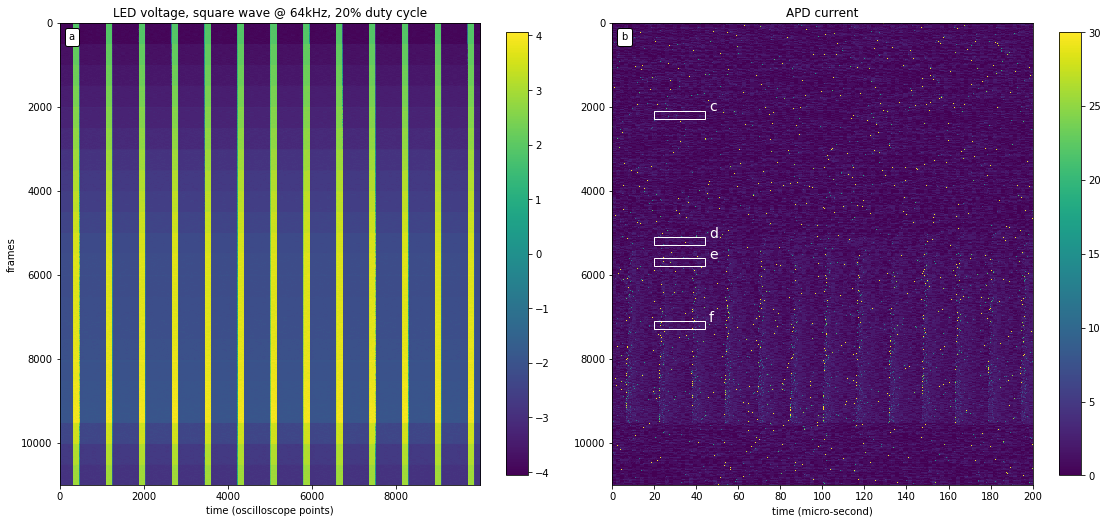

In [14]:
%%time
fig,axx = plt.subplots(1,2,figsize=(16,8))
axx=axx.ravel()
ax=axx[0]
im=ax.imshow(get_ledvoltage(led_data),interpolation=None)
plt.colorbar(im,ax=ax,shrink=0.8)
ax.set_title("LED voltage, square wave @ 64kHz, 20% duty cycle")
ax.set_xlabel("time (oscilloscope points)")
ax.set_ylabel("frames")
max_x_val=1200
ax=axx[1]
im=ax.imshow(np.clip(apd_data,0,30),interpolation=None)
yregions = [2100,5100,5600,7100]
for letter,yregion in zip("cdef",yregions):
    ax.add_patch(Rectangle(( 1000, yregion), max_x_val, 200, fill=None, alpha=1,color="white"))
    ax.text(1000+max_x_val+100,yregion,letter,color="white", fontsize=14)
plt.colorbar(im,ax=ax,shrink=0.8)
ax.set_title("APD current")
ax.set_xlabel("time (micro-second)")
num_xticks = 10
ax.set_xticks(np.arange(0,len(led_data[0])+1,len(led_data[0])//num_xticks))
ax.set_xticklabels([f"{i*SamplingPeriod*1000*1000:.0f}" for i in np.arange(0,len(led_data[0])+1,len(led_data[0])//num_xticks)])

addsubfiglabels(axx)
plt.tight_layout()
plt.savefig("results03_01_apdvoltage.png",dpi=200)

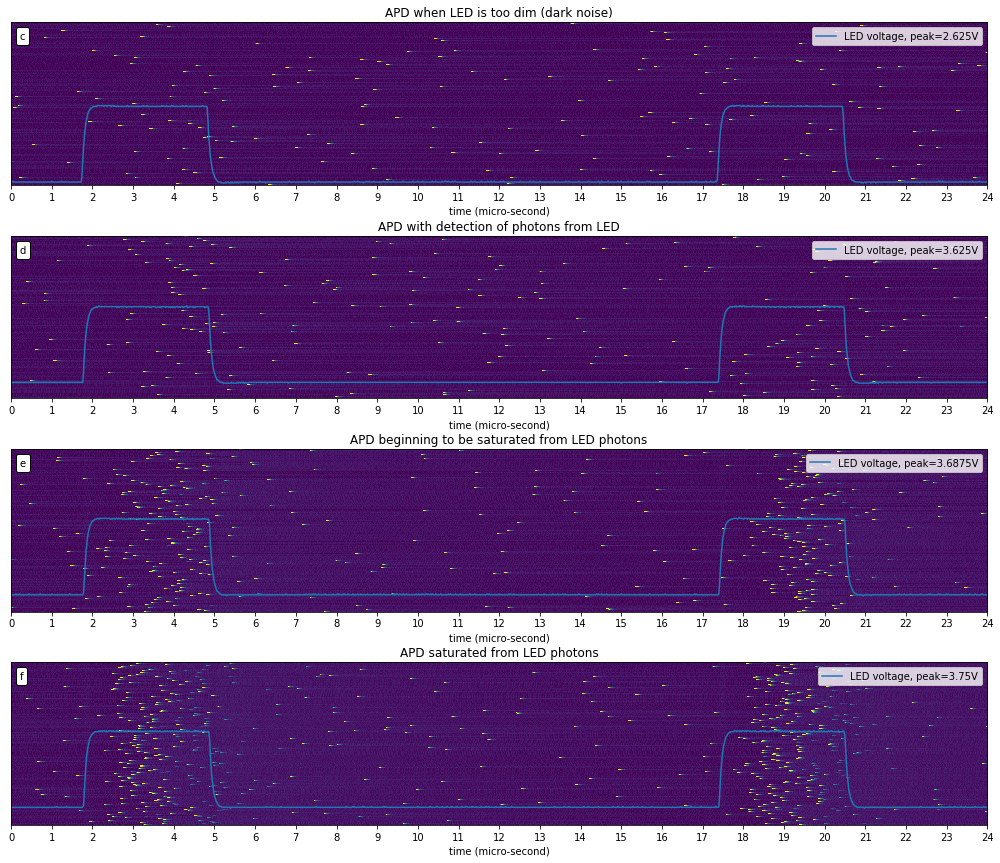

In [15]:
fig,axx = plt.subplots(4,1,figsize=(14,12))
axx=axx.ravel()
titles=["APD when LED is too dim (dark noise)","APD with detection of photons from LED","APD beginning to be saturated from LED photons","APD saturated from LED photons"]
for ax,title,yregion in zip(axx,titles,yregions):
    im=ax.imshow(np.clip(apd_data,0,30)[yregion:yregion+200,1000:1000+max_x_val],interpolation=None,origin="lower")
    ax.plot(led_data[yregion,1000:1000+max_x_val]+55,label=f"LED voltage, peak={get_ledvoltage(max(led_data[yregion,1000:1500]))}V")
    ax.set_yticks([])
    ax.set_title(title)
    
    num_xticks = 24
    ax.set_xticks(np.arange(0,max_x_val+1,max_x_val//num_xticks))
    ax.set_xticklabels([f"{i*SamplingPeriod*1000*1000:.0f}" for i in np.arange(0,max_x_val+1,max_x_val//num_xticks)])
    ax.set_xlabel("time (micro-second)")
    ax.legend()

addsubfiglabels(axx,skip=2)
plt.tight_layout()
plt.savefig("results03_02_apd_zoomed.png",dpi=200)

### average time before each trigger

In [16]:
scope_settings

['Trigger Level,1.040E+00,Trigger Level,1.040E+00',
 'Vertical Scale,5.000e-01,Vertical Scale,1.000e+00',
 'Vertical Position,-1.820e+00,Vertical Position,0.000e+00',
 'Horizontal Scale,2.000E-05,Horizontal Scale,2.000E-05',
 'Sampling Period,2.000e-08,Sampling Period,2.000e-08']

freq=64kHz

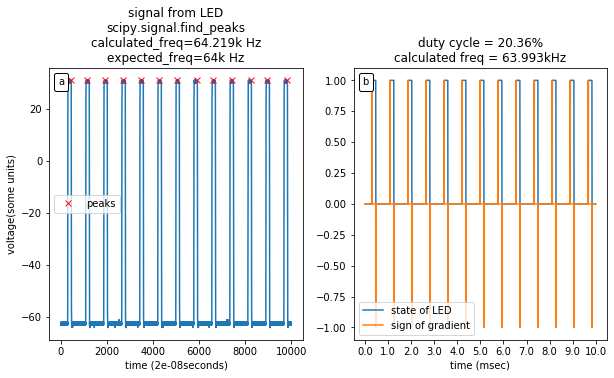

In [39]:
fig,axx = plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
peak_x , peak_heights = find_peaks(led_data[0],height=10,distance=200)
ax.plot(led_data[0],alpha=1)
ax.plot(peak_x,peak_heights["peak_heights"],"x",c="r",alpha=0.96,label="peaks")
average_pixels_per_cycle=np.mean(np.diff(peak_x))
calculated_freq = 1/(sample_period*average_pixels_per_cycle)
expected_freq =64000
diff = np.diff(1*(led_data[0]>np.mean(led_data[0])))
ax.legend()

ax.set_ylabel("voltage(some units)")
ax.set_title("signal from LED\nscipy.signal.find_peaks\n"+f"calculated_freq={Q(calculated_freq)} Hz\nexpected_freq={Q(expected_freq)} Hz")
ax.set_xlabel(f"time ({sample_period}seconds)")
ax=axx[1]
time_x = np.arange(len(led_data[0]))*sample_period
time_on = np.mean(np.where(diff==-1)[0] - np.where(diff==1)[0])
time_off = np.mean(np.where(diff==1)[0][1:]-np.where(diff==-1)[0][:-1])
ax.plot(time_x,led_data[0]>np.mean(led_data[0]),label="state of LED")
ax.plot(time_x[:-1],diff,label="sign of gradient")
ax.legend()
num_xticks = 10
ax.set_xticks(np.arange(0,len(led_data[0])+1,len(led_data[0])//num_xticks)*sample_period)
ax.set_xticklabels([i/1000 for i in np.arange(0,len(led_data[0])+1,len(led_data[0])//num_xticks)])
ax.set_xlabel("time (msec)")
ax.set_title(f"duty cycle = {time_on/(time_off+time_on)*100:.2f}%\n"
             f"calculated freq = {Q(1/sample_period/np.mean(np.diff(np.where(diff==-1)[0])))}Hz")
addsubfiglabels(axx)
plt.savefig("results03_03_ledvoltage.png")

## find the time intervals between peaks

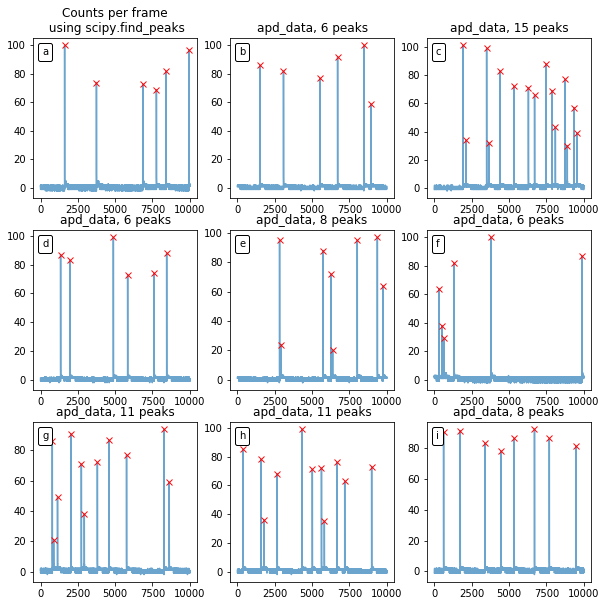

In [18]:
fig,axx = plt.subplots(3,3,figsize=(10,10))
axx=axx.ravel()
for framei,ax in enumerate(axx):
    framei += 300
    peak_x , peak_heights = find_peaks(apd_data[framei],height=10)#,width=2)
    ax.plot(apd_data[framei],alpha=0.66)
    ax.plot(peak_x,peak_heights["peak_heights"],"x",c="r",alpha=0.96)
    ax.set_title(f"apd_data, {len(peak_x)} peaks")
axx[0].set_title("Counts per frame\n using scipy.find_peaks")
addsubfiglabels(axx)
plt.savefig("results03_04_darkcounts.png")

CPU times: user 463 ms, sys: 0 ns, total: 463 ms
Wall time: 462 ms


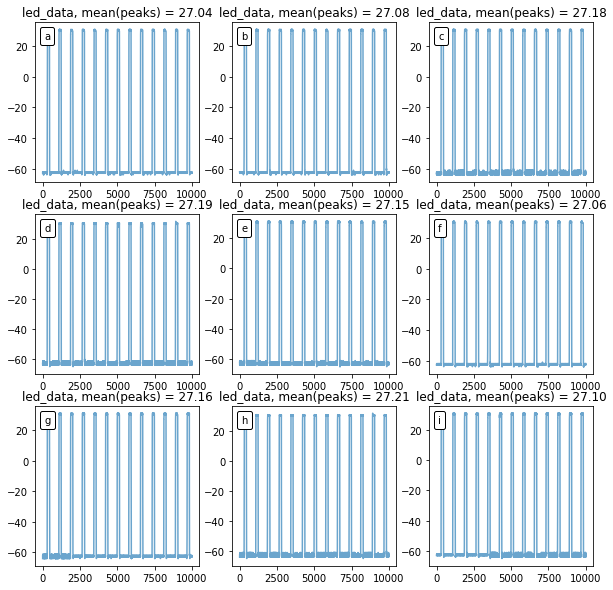

In [19]:
%%time
fig,axx = plt.subplots(3,3,figsize=(10,10))
for framei,ax in enumerate(axx.ravel()):
    framei += 300
    ax.plot(led_data[framei],alpha=0.66)
    meanheight= np.mean(led_data[framei][np.where(led_data[framei]>np.mean(led_data[framei]))])
    ax.set_title(f"led_data, mean(peaks) = { meanheight :.2f}")
addsubfiglabels(axx)
plt.savefig("results03_05_led_voltage.png")

In [41]:
%%time
darkcounts =[]
average_peak_led = []
apd_peaks = []
for framei in range(len(apd_data)):
    peak_x , peak_heights = find_peaks(apd_data[framei],height=10)
    darkcounts .append(len(peak_x))
    apd_peaks.append((peak_x,peak_heights["peak_heights"]))
    meanheight= np.mean(led_data[framei][np.where(led_data[framei]>np.mean(led_data[framei]))])
    average_peak_led.append( meanheight )

CPU times: user 1.52 s, sys: 3.32 ms, total: 1.53 s
Wall time: 1.53 s


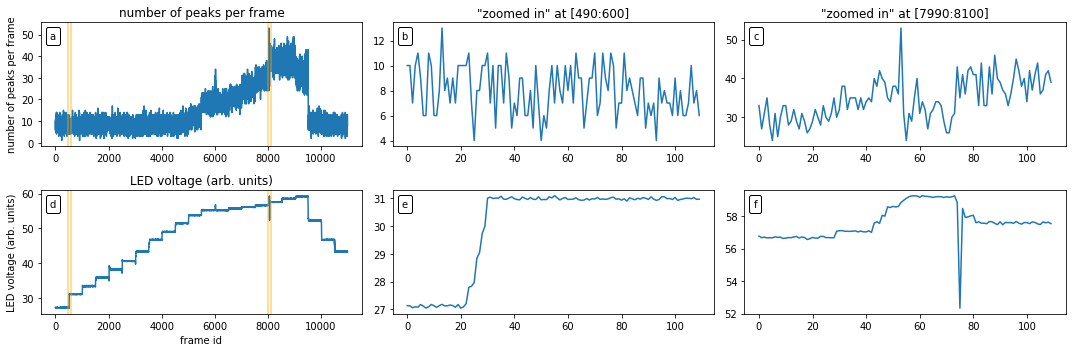

In [21]:
fig,axx = plt.subplots(2,3,figsize=(15,5))

ax = axx[0,0]
ax.plot(darkcounts)
ax.set_ylabel("number of peaks per frame")
ax.set_title("number of peaks per frame")
ax = axx[1,0]
ax.plot(average_peak_led)
ax.set_ylabel("LED voltage (arb. units)")
ax.set_title("LED voltage (arb. units)")
ax.set_xlabel("frame id")

ax = axx[0,1]
ax.set_title('"zoomed in" at [490:600]')
ax.plot(darkcounts[490:600])
ax = axx[1,1]
ax.plot(average_peak_led[490:600]) 

ax = axx[0,2]
ax.set_title('"zoomed in" at [7990:8100]')
ax.plot(darkcounts[7990:8100])
ax = axx[1,2]
ax.plot(average_peak_led[7990:8100]) 
for i in [0,1]:
    axx[i,0].axvline(490,color="orange",alpha=0.5)
    axx[i,0].axvline(600,color="orange",alpha=0.5)
    axx[i,0].axvline(7990,color="orange",alpha=0.5)
    axx[i,0].axvline(8100,color="orange",alpha=0.5)
plt.tight_layout()
addsubfiglabels(axx)
plt.savefig("results03_06_averaged_crosssection_of_data.png")

### retrieving windows when LED voltage is stable

In [22]:
from collections import OrderedDict
good_frames =OrderedDict() 
minled = np.inf; maxled = -np.inf
for i in range(len(average_peak_led)//500):
    roi_led = average_peak_led[90+i*500:490+i*500]
    roi_darkcounts = darkcounts[90+i*500:490+i*500]
    roi_apd = apd_data[80+i*500:490+i*500]
    minled = min(minled,np.median(roi_led)) ; maxled = max(maxled,np.median(roi_led)) 
    good_frames[f"{np.mean(roi_led):.5f}"] = {"led":roi_led,"roi_darkcounts":roi_darkcounts,"roi_apd":roi_apd}

CPU times: user 1.71 s, sys: 19.4 ms, total: 1.73 s
Wall time: 1.73 s


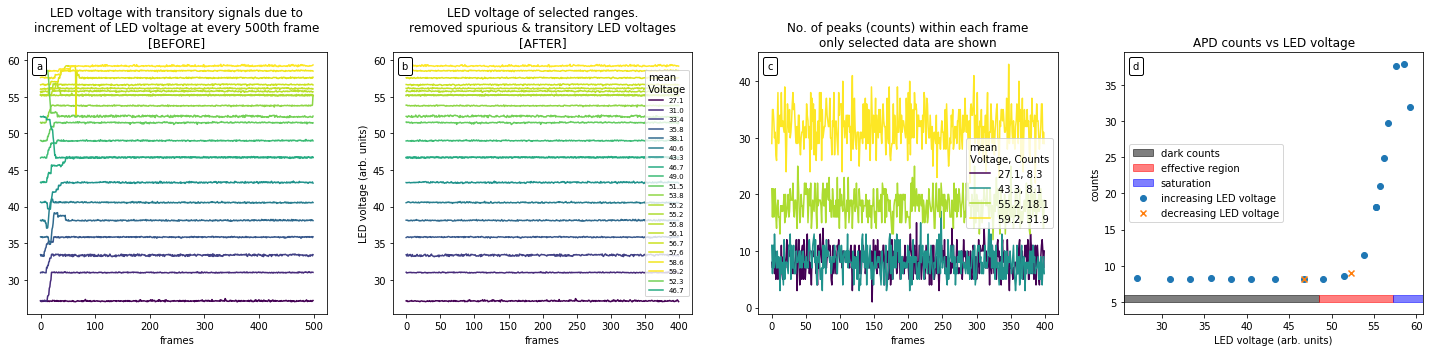

In [23]:
%%time

fig,axx = plt.subplots(1,4,figsize=(20,5))
for i in range(len(average_peak_led)//500):
    roi_led = average_peak_led[90+i*500:490+i*500]
    roi_darkcounts = darkcounts[90+i*500:490+i*500]
    medianled=np.mean(roi_led)
    axx[1].plot(roi_led,c=plt.cm.viridis((medianled-minled)/(maxled-minled)),label=f"{medianled:.1f}") 
    axx[0].plot(average_peak_led[i*500:500+i*500],c=plt.cm.viridis((medianled-minled)/(maxled-minled)))
    if i % 6==0:
        axx[2].plot(roi_darkcounts,label=f"{medianled:.1f}, {np.mean(roi_darkcounts):.1f}",c=plt.cm.viridis((medianled-minled)/(maxled-minled)))
axx[2].legend(title="mean\nVoltage, Counts",loc="right")
axx[2].set_title("No. of peaks (counts) within each frame\nonly selected data are shown")
axx[2].set_xlabel("frames")
axx[1].legend(title="mean\nVoltage",fontsize=7,loc="right")
axx[1].set_title("LED voltage of selected ranges.\nremoved spurious & transitory LED voltages\n[AFTER]")
axx[1].set_ylabel("LED voltage (arb. units)")
axx[1].set_xlabel("frames")

axx[0].set_title("LED voltage with transitory signals due to\nincrement of LED voltage at every 500th frame\n[BEFORE]")
axx[0].set_xlabel("frames")
avg_counts_temp= [ ];avg_led_temp=[]
for led,dictt in good_frames.items():
    avg_counts_temp.append(float(np.mean(dictt["roi_darkcounts"])))
    avg_led_temp.append(float(led))
ax=axx[3]    
ax.scatter(avg_led_temp[:-2],avg_counts_temp[:-2],marker="o",label="increasing LED voltage")
ax.scatter(avg_led_temp[-2:],avg_counts_temp[-2:],marker="x",label="decreasing LED voltage") 
ax.axhspan(5,6,0,0.65,color="k",alpha=0.5,label="dark counts")
ax.axhspan(5,6,0.65,0.90,color="r",alpha=0.5,label="effective region")
ax.axhspan(5,6,0.90,1,color="b",alpha=0.5,label="saturation")
ax.legend(loc="center left")
ax.set_ylabel("counts")
ax.set_xlabel("LED voltage (arb. units)")
ax.set_title("APD counts vs LED voltage")
plt.tight_layout()
addsubfiglabels(axx)
plt.savefig("results03_07_ledvoltagelevels_selection.png",dpi=150)

### getting the poisson statistics of counts

Each frame as an interval of 10 milli seconds in real time.

On average, x peaks are present in each frame (averaged over 400 frames)

Assuming the peaks are independent of each other, x should follow a poisson distribution

In [64]:
%%time
roi_darkcounts = [good_frames[key]["roi_darkcounts"] for key in good_frames.keys() if float(key)<45]
roi_darkcounts = np.array(roi_darkcounts).reshape(-1)

peak_vec_x = []
peak_vec_height = []
dark_peaks = []
for key in good_frames.keys():
    if float(key)>=45:
        continue
    for i in range(len(good_frames[key]['roi_apd'])):
        roi_apd=good_frames[key]['roi_apd'][i]
        peak_x , peak_heights = find_peaks(roi_apd,height=10)
        dark_peaks.append( (peak_x,peak_heights["peak_heights"]) )
        for _x,_y in zip(np.diff(peak_x),np.diff(peak_heights["peak_heights"])):
            peak_vec_x.append(_x)
            peak_vec_height.append(_y)

CPU times: user 907 ms, sys: 0 ns, total: 907 ms
Wall time: 906 ms


In [65]:
good_frames.keys()

odict_keys(['27.11306', '30.99287', '33.36449', '35.83639', '38.11467', '40.55258', '43.29724', '46.72126', '49.00428', '51.46791', '53.77853', '55.22375', '55.21089', '55.75713', '56.14086', '56.65644', '57.58026', '58.55233', '59.22299', '52.32537', '46.71663'])

CPU times: user 1.31 s, sys: 16 ms, total: 1.32 s
Wall time: 1.32 s


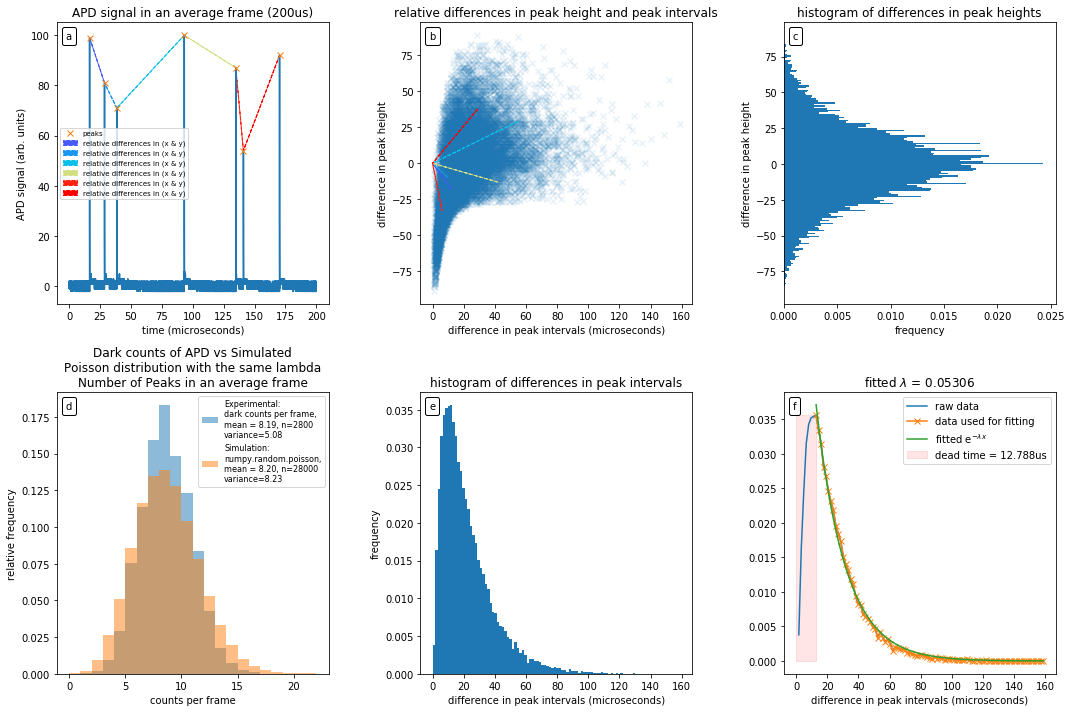

In [66]:
%%time 
fig,axx = plt.subplots(2,3,figsize=(15,10))
axx=axx.ravel()
ax=axx[0]
handles = [];labels=[]
roi_apd=good_frames["38.11467"]['roi_apd'][4]
ax.plot(np.arange(len(roi_apd))*SamplingPeriod*1e6,roi_apd)
peak_x , peak_heights = find_peaks(roi_apd,height=10)
plothandle, = ax.plot(peak_x*SamplingPeriod*1e6,peak_heights["peak_heights"],"x",label="peaks")
handles.append(plothandle);labels.append("peaks")
for _x,_y,_dx,_dy in zip(peak_x[:-1],peak_heights["peak_heights"][:-1],
                         np.diff(peak_x),np.diff(peak_heights["peak_heights"])):
    arrows = ax.arrow(_x*SamplingPeriod*1e6,_y,_dx*SamplingPeriod*1e6,_dy,color=plt.cm.rainbow(_x/max(peak_x[:-1])),ls="--")
    handles.append(arrows);labels.append("relative differences in (x & y)")
ax.set_title(f"APD signal in an average frame ({Q(SamplingPeriod*1e4)}s)")
ax.legend(handles,labels,fontsize=7,loc="center left")
ax.set_ylabel("APD signal (arb. units)")
ax.set_xlabel("time (microseconds)")

ax=axx[3]
ax.set_title("Dark counts of APD vs Simulated\nPoisson distribution with the same lambda\n"+
             "Number of Peaks in an average frame")
ax.hist(roi_darkcounts,bins=np.arange(min(roi_darkcounts),max(roi_darkcounts)+1),
         label=f"Experimental:\ndark counts per frame,\nmean = {np.mean(roi_darkcounts):.2f},"
        f" n={len(roi_darkcounts)}\nvariance={np.std(roi_darkcounts)**2:.2f}",density=True,alpha=0.5);
rand = np.random.poisson(np.mean(roi_darkcounts),size=len(roi_darkcounts)*10)
ax.hist(rand,bins=np.arange(min(rand),max(rand)+1),
         label=f"Simulation:\nnumpy.random.poisson,\nmean = {np.mean(rand):.2f},"
        f" n={len(roi_darkcounts)*10}\nvariance={np.std(rand)**2:.2f}",density=True,alpha=0.5);
ax.legend(fontsize=8)
ax.set_ylabel("relative frequency")
ax.set_xlabel("counts per frame")

ax=axx[1]

ax.scatter(np.array(peak_vec_x).reshape(-1)*SamplingPeriod*1e6,np.array(peak_vec_height).reshape(-1),marker="x",alpha=0.1)
for _x,_y,_dx,_dy in zip(peak_x[:-1],peak_heights["peak_heights"][:-1],
                        np.diff(peak_x),np.diff(peak_heights["peak_heights"])):
    ax.arrow(0,0,_dx*SamplingPeriod*1e6,_dy,color=plt.cm.rainbow(_x/max(peak_x[:-1])),ls="--")
ax.set_title("relative differences in peak height and peak intervals")
ax.set_ylabel("difference in peak height")
ax.set_xlabel("difference in peak intervals (microseconds)")

ax=axx[2]
ax.hist(np.array(peak_vec_height).reshape(-1),orientation ="horizontal",density=True,
        bins=np.arange(np.min(peak_vec_height),np.max(peak_vec_height)+2))
ax.set_title("histogram of differences in peak heights")
ax.set_ylabel("difference in peak height")
ax.set_xlabel("frequency")

ax=axx[4]
heights,bins ,_=ax.hist(np.array(peak_vec_x).reshape(-1)*SamplingPeriod*1e6,density=True,bins=100)#np.arange(np.min(peak_vec_x),np.max(peak_vec_x)+2))
ax.set_title("histogram of differences in peak intervals")
ax.set_xlabel("difference in peak intervals (microseconds)")
ax.set_ylabel("frequency")

ax = axx[5]
from scipy.optimize import curve_fit
def exp_func(x,lamb,a): #https://towardsdatascience.com/what-is-exponential-distribution-7bdd08590e2a
    return a*np.exp(-lamb*x)
# np.histogram( np.array(peak_vec_x).reshape(-1) )
fittingx = bins[np.argmax(heights)+1+0:]
fittingy =heights[np.argmax(heights)+0:] 
popt,_=curve_fit(exp_func,fittingx,fittingy,p0=[0.001,1/800])

ax.plot(bins[1:],heights,label="raw data")
ax.plot(fittingx,fittingy,"x-",label="data used for fitting")
#ax.axvline(fittingx[0],ls="--",color="red")
ax.set_title(r"fitted $\lambda$ = "+f"{popt[0]:.5f}")
ax.plot(fittingx,exp_func(fittingx,*popt),label=r"fitted e$^{-\lambda x}$")
ax.fill_betweenx(fittingy,0,fittingx[0],color="red",alpha=0.1,label=f"dead time = {Q(fittingx[0]*1e-6)}s")
ax.set_xlabel("difference in peak intervals (microseconds)")
ax.legend()
addsubfiglabels(axx)
plt.tight_layout()
plt.savefig("results03_08_distribution_of_peaks.png",dpi=150)

In [67]:
15000 # cps counts per sec (sap500 dark count rate)

15000

In [68]:
print(8.19/(SamplingPeriod*1e4),"average counts per second")

40949.99999999999 average counts per second


In [69]:
SamplingPeriod

2e-08

In [70]:
0.05324*1e6

53240.0

## trying with the conventional absolute trigger

In [71]:
len(apd_peaks[330][0]),len(apd_peaks[330][1])

(9, 9)

In [72]:
100e-9*560e3,3.3e-12*560e3

(0.055999999999999994, 1.8480000000000001e-06)

In [73]:
trigger = 80
sum([len(apd_peaks[i][0])==0 for i in range(len(apd_peaks))])

0

In [ ]:
dark_peak_heights =[height for i in range(len(dark_peaks))  for height in dark_peaks[i][1]]
dark_peak_times =[height for i in range(len(dark_peaks))  for height in dark_peaks[i][0]]

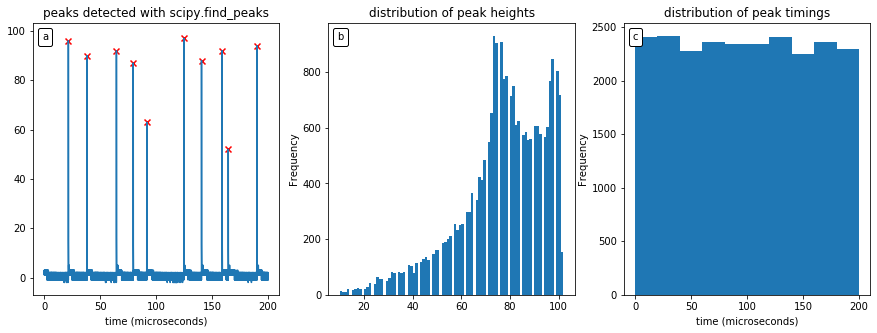

In [151]:
i=0
fig,axx=plt.subplots(1,3,figsize=(15,5))
axx[0].plot(np.arange(len(apd_data[i]))*SamplingPeriod*1e6,apd_data[i])
axx[0].scatter(apd_peaks[i][0]*SamplingPeriod*1e6,apd_peaks[i][1],marker="x",color="r")
axx[0].set_title("peaks detected with scipy.find_peaks")
axx[0].set_xlabel("time (microseconds)")
axx[1].hist(dark_peak_heights,bins=np.arange(min(dark_peak_heights),max(dark_peak_heights)+1));
axx[1].set_title("distribution of peak heights")
axx[1].set_ylabel("Frequency")
axx[2].hist(np.asarray(dark_peak_times)*SamplingPeriod*1e6);
axx[2].set_title("distribution of peak timings")
axx[2].set_xlabel("time (microseconds)")
axx[2].set_ylabel("Frequency")
addsubfiglabels(axx)
plt.show()

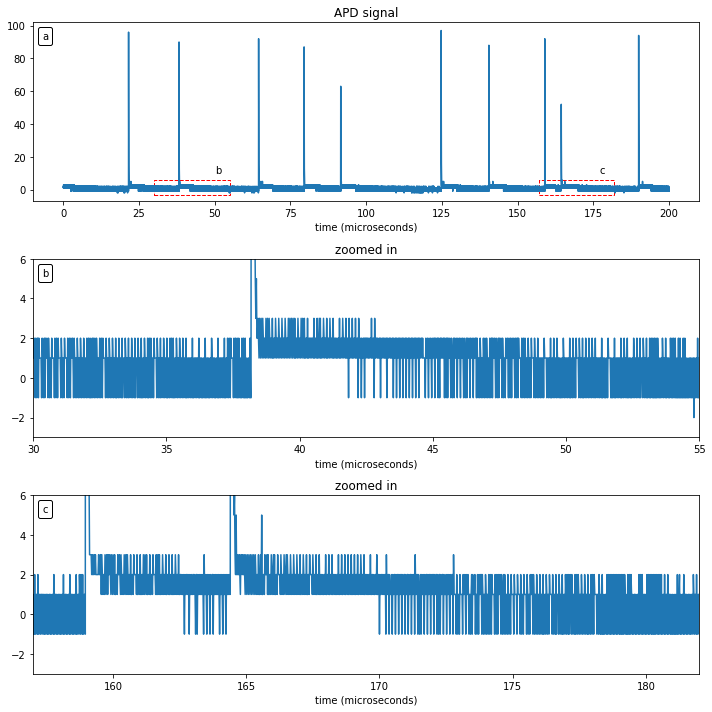

In [149]:
i=0
fig,axx=plt.subplots(3,1,figsize=(10,10))
ax = axx[0]
ax.plot(np.arange(len(apd_data[i]))*SamplingPeriod*1e6,apd_data[i])
ax.add_patch(plt.Rectangle((30,-3),25,9,ls="--",color="red",fill=None))
ax.text(30+20,10,"b")
ax.add_patch(plt.Rectangle((157,-3),25,9,ls="--",color="red",fill=None))
ax.text(157+20,10,"c")
ax.set_xlabel("time (microseconds)")
ax.set_title("APD signal")
ax = axx[1]
ax.plot(np.arange(len(apd_data[i]))*SamplingPeriod*1e6,apd_data[i])
ax.set_ylim(-3,6)
ax.set_xlim(30,55)
ax.set_xlabel("time (microseconds)")
ax.set_title("zoomed in")
ax = axx[2]
ax.plot(np.arange(len(apd_data[i]))*SamplingPeriod*1e6,apd_data[i])
ax.set_ylim(-3,6)
ax.set_xlim(157,157+25)
ax.set_xlabel("time (microseconds)")
ax.set_title("zoomed in")
addsubfiglabels(axx)
plt.tight_layout()